#### This notebook will be used for Coursera Capstone Project. The project is about segmenting and clustering neighborhoods in Toronto.

##### Importing libraries

In [69]:
# For data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# To handle data in a vectorized manner
import numpy as np

# To handle requests
import requests

# To handle JSON files
import json 
# To tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# To parse html page
from bs4 import BeautifulSoup
from bs4 import SoupStrainer

# To convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# K-means from clustering stage
from sklearn.cluster import KMeans

# Map rendering library
#!pip install folium==0.5.0
import folium 
%matplotlib inline

## Part 1 - Beautiful Soup

### Getting Toronto Data

In [2]:
# Requesting the data from url
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [3]:
# Condition to extract only table
only_table = SoupStrainer('table',attrs={'class':'wikitable sortable'}) # Condition to p
soup = BeautifulSoup(page,'html.parser',parse_only=only_table)
# Condition to extract rows
only_rows = SoupStrainer('tr')
# Condition to extract data from rows
def only_data(lst):
    return [[d.text.rstrip() for d in li.find_all(['td'])] for li in lst] 

data = only_data(soup.find_all(only_rows))

###### Creating a Data Frame with columns PostalCode, Borough, Neighborhood and the scraped data

In [4]:
toronto_data = pd.DataFrame(data = data, columns = ['PostalCode','Borough','Neighborhood'])[1:]

### Cleaning Toronto Data

##### Finding cells where Borough is assigned and Neighborhood is not assigned

In [5]:
toronto_data[(toronto_data['Borough'] != 'Not assigned') & (toronto_data['Neighborhood'] == 'Not assigned')]

,PostalCode,Borough,Neighborhood
9,M7A,Queen's Park,Not assigned


In [6]:
toronto_data.loc[9,'Neighborhood'] = "Queen's Park"

##### Removing rows where Borough is Not assigned

In [7]:
toronto_data = toronto_data[toronto_data['Borough'] != 'Not assigned']

###### Combining neighborhoods in one postal code area

In [8]:
toronto_data = toronto_data.groupby(['PostalCode','Borough']).Neighborhood.apply(lambda x: ', '.join(x)).reset_index()

##### Printing the shape and the first few rows of the data

In [9]:
print(toronto_data.shape)
toronto_data.head(10)

(103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


## Part 2 - Geocodes

In [10]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
Postal Code    103 non-null object
Latitude       103 non-null float64
Longitude      103 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.5+ KB


In [12]:
# Merging the toronto dataset and geo_data on 
toronto_data = pd.merge(toronto_data,geo_data,left_on=['PostalCode'],right_on=['Postal Code'])

In [13]:
# Dropping Postal Code since PostalCode contains the same information
toronto_data.drop(columns=['Postal Code'],inplace = True)

In [14]:
toronto_data.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## Part 3 - Exploring Neighborhoods in Toronto

Let's see how many boroughs Toronto has and what are they:

In [15]:
print('The number of boroughs in Toronto is', toronto_data.Borough.nunique())
print('They are:', toronto_data.Borough.unique())

The number of boroughs in Toronto is 11
They are: ['Scarborough' 'North York' 'East York' 'East Toronto' 'Central Toronto'
 'Downtown Toronto' 'York' 'West Toronto' "Queen's Park" 'Mississauga'
 'Etobicoke']


#### Use geopy library to get the latitude and longitude values of Toronto.

In [16]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [17]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location = [latitude,longitude],zoom_start = 10)
# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'],
                                           toronto_data['Longitude'],
                                           toronto_data['Borough'],
                                           toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='blue',
                        fill=True,fill_color='#3186cc',fill_opacity=0.5,
                        parse_html=False).add_to(map_toronto)
map_toronto

However, for illustration purposes, let's simplify the above map and segment and cluster only the boroughs that contain Toronto. So let's slice the original dataframe and create a new dataframe of the Toronto borough data.

In [18]:
toronto_list = ['East Toronto','Central Toronto',
                'Downtown Toronto','West Toronto']

In [19]:
toronto = toronto_data[toronto_data['Borough'].isin(toronto_list)].reset_index(drop=True)

In [20]:
# create map of Toronto boroughs using latitude and longitude values
map_toronto = folium.Map(location = [latitude,longitude],zoom_start = 11)
# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'],
                                           toronto['Longitude'],
                                           toronto['Borough'],
                                           toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood,borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='blue',
                        fill=True,fill_color='#3186cc',fill_opacity=0.5,
                        parse_html=False).add_to(map_toronto)
map_toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [21]:
CLIENT_ID = 'CL4V5A2CB10V5UWGB0EV04N23TOUFV34SLKCXXP3XGSTBS3W' # your Foursquare ID
CLIENT_SECRET = 'EI1OR45QYMGUBPXHW4RTTDT5XYH0ZYLNWZ3QJ3KYQQWNGW2Z' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Exploring Neighborhoods in selected boroughs

#### Let's explore the first neighborhood in our dataframe.
Get the neighborhood's name.

In [22]:
toronto.loc[0, 'Neighborhood']

'The Beaches'

Get the neighborhood's latitude and longitude values.

In [23]:
neighborhood_latitude = toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = toronto.loc[0, 'Neighborhood'] # neighborhood name

#### Now, let's get the top 100 venues that are in The Beaches within a radius of 500 meters.
First, let's create the GET request URL. Name your URL **url**.

In [24]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                            CLIENT_SECRET,
                                                                                                                            VERSION,
                                                                                                                            neighborhood_latitude,
                                                                                                                            neighborhood_longitude,
                                                                                                                            radius,
                                                                                                                            LIMIT)
                                                                                                                            
url

'https://api.foursquare.com/v2/venues/explore?&client_id=CL4V5A2CB10V5UWGB0EV04N23TOUFV34SLKCXXP3XGSTBS3W&client_secret=EI1OR45QYMGUBPXHW4RTTDT5XYH0ZYLNWZ3QJ3KYQQWNGW2Z&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

Send the GET request and examine the resutls

In [25]:
results = requests.get(url).json()

In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [27]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Grover Pub and Grub,Pub,43.679181,-79.297215
1,Starbucks,Coffee Shop,43.678798,-79.298045
2,St-Denis Studios Inc.,Music Venue,43.675031,-79.288022
3,Upper Beaches,Neighborhood,43.680563,-79.292869


#### Let's create a function to repeat the same process to all the neighborhoods

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the function above for each of the Neighborhoods

In [30]:
ns = toronto['Neighborhood']
lts = toronto['Latitude']
lgs = toronto['Longitude']
toronto_venues = getNearbyVenues(names=ns,latitudes=lts,longitudes=lgs)

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

#### Let's check the size of the resulting dataframe

In [31]:
print(toronto_venues.shape)
toronto_venues.head()

(1697, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
1,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
2,The Beaches,43.676357,-79.293031,St-Denis Studios Inc.,43.675031,-79.288022,Music Venue
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Let's check how many venues were returned for each neighborhood

In [32]:
toronto_venues.groupby('Neighborhood')[['Venue']].count().sort_values(by=['Venue'],ascending=False)

,Venue
Neighborhood,
"Adelaide, King, Richmond",100
"Chinatown, Grange Park, Kensington Market",100
St. James Town,100
"Ryerson, Garden District",100
"First Canadian Place, Underground city",100
"Design Exchange, Toronto Dominion Centre",100
"Commerce Court, Victoria Hotel",100
"Harbourfront East, Toronto Islands, Union Station",100
Stn A PO Boxes 25 The Esplanade,95


#### Let's find out how many unique categories can be curated from all the returned venues

In [33]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


### Analyzing Each Neighborhood

In [34]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

In [37]:
toronto_onehot.head()

,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [35]:
toronto_onehot.shape

(1697, 234)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [38]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped 

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.00,0.010000,0.010000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.020000,0.000000,0.01,0.020000,0.000000,0.000000,0.01,0.020000,0.010000,0.0,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.060000,0.000000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.00,0.000000,0.000000,0.00

#### Let's confirm the new size

In [39]:
toronto_grouped.shape

(38, 234)

#### Let's print each neighborhood along with the top 5 most common venues

In [44]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2  American Restaurant  0.04
3           Steakhouse  0.04
4      Thai Restaurant  0.04


----Berczy Park----
            venue  freq
0     Coffee Shop  0.07
1      Restaurant  0.05
2    Cocktail Bar  0.05
3          Bakery  0.04
4  Farmers Market  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0  Breakfast Spot  0.11
1            Café  0.11
2     Coffee Shop  0.11
3             Gym  0.06
4   Burrito Place  0.06


----Business reply mail Processing Centre969 Eastern----
           venue  freq
0    Pizza Place  0.06
1     Restaurant  0.06
2     Skate Park  0.06
3            Spa  0.06
4  Burrito Place  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.14
1   Airport Service  0.14
2  Airport Terminal  0.14
3         

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,American Restaurant,Steakhouse,Thai Restaurant,Restaurant,Gym,Hotel,Bar,Bakery
1,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Seafood Restaurant,Pub,Italian Restaurant,Bakery,Café,Farmers Market,Steakhouse
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Coffee Shop,Café,Performing Arts Venue,Burrito Place,Stadium,Bar,Caribbean Restaurant,Furniture / Home Store,Italian Restaurant
3,Business reply mail Processing Centre969 Eastern,Farmers Market,Auto Workshop,Pizza Place,Recording Studio,Butcher,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Boat or Ferry
5,"Cabbagetown, St. James Town",Pizza Place,Restaurant,Coffee Shop,Indian Restaurant,Bakery,Park,Italian Restaurant,Pub,Market,Café
6,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Chinese Restaurant,Ice Cream Shop,Burger Joint,Bar,Sandwich Place,Salad Place,Bubble Tea Shop
7,"Chinatown, Grange Park, Kensington Market",Bar,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Bakery,Vietnamese Restaurant,Dumpling Restaurant,Mexican Restaurant,Chinese Restaurant,Burger Joint
8,Christie,Café,Grocery Store,Park,Convenience Store,Nightclub,Baby Store,Diner,Restaurant,Italian Restaurant,Coffee Shop
9,Church and Wellesley,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Gay Bar,Burger Joint,Restaurant,Men's Store,Café,Mediterranean Restaurant,Fast Food Restaurant


## Part 4 - Clustering Neighborhoods in Toronto

In [48]:
toronto_grouped.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.0,0.0,0.0,0.010000,0.01,0.0,0.03,0.000000,0.0,0.0,0.000000,0.030000,0.0,0.030000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.02,0.000000,0.01,0.020000,0.000000,0.0,0.01,0.02,0.010000,0.0,0.000000,0.050000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.030000,0.010000,0.060000,0.0,0.0,0.0,0.000000,0.000000,0.020000,0.000000,0.020000,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.

Let's first identify the number of optimum clusters by using the elbow rule

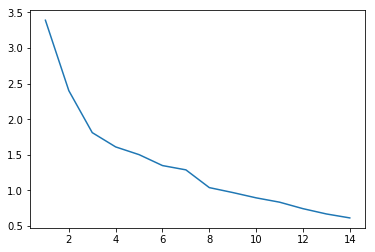

In [70]:
K = range(1,15)
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
wcss = [KMeans(n_clusters=i,random_state=0).fit(toronto_grouped_clustering ).inertia_ for i in K]
plt.plot(range(1,15),wcss)

Run *k*-means to cluster the neighborhood into 6 clusters.

In [71]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [72]:
toronto_merged = toronto

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge neighborhoods_venues_sorted with toronto to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Music Venue,Coffee Shop,Pub,Yoga Studio,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant,Caribbean Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Park,Gym,Sandwich Place,Italian Restaurant,Steakhouse,Fish & Chips Shop,Fast Food Restaurant,Liquor Store,Brewery,Burger Joint
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Seafood Restaurant,Sandwich Place,Cheese Shop
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Bus Line,Park,Lake,Dim Sum Restaurant,Swim School,Yoga Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


Finally, let's visualize the resulting clusters

In [73]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], 
                                  toronto_merged['Longitude'], 
                                  toronto_merged['Neighborhood'],
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

#### Cluster 1: Japanese Cuisine and Flea/Arts

In [74]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Downtown Toronto,0,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Gay Bar,Burger Joint,Restaurant,Men's Store,Café,Mediterranean Restaurant,Fast Food Restaurant
34,West Toronto,0,Mexican Restaurant,Café,Flea Market,Arts & Crafts Store,Fast Food Restaurant,Sandwich Place,Bookstore,Park,Speakeasy,Cajun / Creole Restaurant


#### Cluster 2 : Coffeed Shops, Cafes, Parks, Trails, Groceries

In [75]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,1,Music Venue,Coffee Shop,Pub,Yoga Studio,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
1,East Toronto,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant,Caribbean Restaurant
2,East Toronto,1,Park,Gym,Sandwich Place,Italian Restaurant,Steakhouse,Fish & Chips Shop,Fast Food Restaurant,Liquor Store,Brewery,Burger Joint
3,East Toronto,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Seafood Restaurant,Sandwich Place,Cheese Shop
4,Central Toronto,1,Bus Line,Park,Lake,Dim Sum Restaurant,Swim School,Yoga Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
5,Central Toronto,1,Park,Food & Drink Shop,Hotel,Breakfast Spot,Burger Joint,Sandwich Place,Yoga Studio,Doner Restaurant,Farmers Market,Falafel Restaurant
6,Central Toronto,1,Sporting Goods Shop,Coffee Shop,Clothing Store,Yoga Studio,Chinese Restaurant,Dessert Shop,Rental Car Location,Diner,Salon / Barbershop,Sandwich Place
7,Central Toronto,1,Dessert Shop,Sandwich Place,Sushi Restaurant,Café,Pizza Place,Coffee Shop,Pharmacy,Italian Restaurant,Seafood Restaurant,Farmers Market
8,Central Toronto,1,Trail,Playground,Gym,Park,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
9,Central Toronto,1,Coffee Shop,Pub,Supermarket,Fried Chicken Joint,Bagel Shop,Sports Bar,American Restaurant,Pizza Place,Light Rail Station,Vietnamese Restaurant


#### Cluster 3: Restaurants

In [76]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Downtown Toronto,2,Coffee Shop,Restaurant,Café,Italian Restaurant,Pub,Seafood Restaurant,Cocktail Bar,Hotel,Japanese Restaurant,Creperie


#### Cluster 4: Breakfast and Gifts

In [77]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,West Toronto,3,Breakfast Spot,Gift Shop,Italian Restaurant,Eastern European Restaurant,Restaurant,Movie Theater,Bookstore,Bar,Dog Run,Burger Joint


#### Cluster 5: Airport and Lunch places

In [78]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Downtown Toronto,4,Coffee Shop,Café,Italian Restaurant,Chinese Restaurant,Ice Cream Shop,Burger Joint,Bar,Sandwich Place,Salad Place,Bubble Tea Shop
24,Central Toronto,4,Coffee Shop,Café,Sandwich Place,Pizza Place,History Museum,Indian Restaurant,Cosmetics Shop,Pharmacy,Pub,Burger Joint
27,Downtown Toronto,4,Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boutique,Boat or Ferry


#### Cluster 6: Yoga and Garden

In [79]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,5,Garden,Yoga Studio,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
